In [515]:
import pandas as pd
import sklearn
import numpy as np
import matplotlib.pyplot as plt
from sklearn.ensemble import RandomForestClassifier 
from sklearn.model_selection import KFold
from sklearn.cross_validation import KFold, cross_val_score,train_test_split
from sklearn.metrics import classification_report
from sklearn.metrics import classification_report, accuracy_score, confusion_matrix
from sklearn.metrics import confusion_matrix
import matplotlib as mpl
mpl.rc('xtick', labelsize=25) 
mpl.rc('ytick', labelsize=25)
import itertools
%matplotlib inline
from sklearn.externals import joblib
from collections import Counter
from imblearn.over_sampling import SMOTE
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import f_classif
from sklearn.model_selection import ShuffleSplit
from sklearn.model_selection import learning_curve
from sklearn.model_selection import StratifiedKFold
from sklearn.utils import shuffle 

# 1、导入训练集

In [426]:
# 读取训练集
train = pd.read_pickle("/home/zhh/文档/阿里巴巴/data/6.合表/训练集总表v3.pickle")
train = train.drop(['上中下旬','个人编码'],axis=1)
train["一次性医用材料申报金额"]=train.fillna(train["一次性医用材料申报金额"].median())
train.columns
X = train.drop(["标签"],axis = 1)
y = train["标签"]

# 2、特征抽取
---
> * smote抽样：

In [427]:
# 抽样
def smote_resampling(random_state,ratio,X,y):
    '''
    描述：
        这是一个以SMOTE算法为和核心的抽样方法。
    
    参数：
        1、ration(tuple):请已元组的形式输入正负样本比例值。
        2、random_state(int):随机种子数，默认值为42
        3、X(pd.DataFrame):训练集
        4、y(pd.DataFrame):测试集
    
    '''
    
    p_shape = y.value_counts().loc[1]  # 正样本数
    n_shape = y.value_counts().loc[0]  #负样本
    
    new_p_shape = int(n_shape * (ratio[0]/ratio[1])) # 按比例抽取
    
    rus = SMOTE(ratio={0:n_shape,1:new_p_shape},random_state=random_state)  # 设置比例
    X_res, y_res = rus.fit_sample(X, y)  #训练
    X_res = pd.DataFrame(X_res,columns =X.columns) # 重组成DataFrame
    print("*********抽样过后的比例********************")
    print(Counter(y_res))
    return X_res,y_res

In [428]:
# ************画混淆矩阵图***************************************
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    plt.figure(figsize = (10,10))
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j],
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

In [573]:
def plot_feature_import(clf,X_train):
    a = []
    for i,j in enumerate(clf.feature_importances_):
        a.append([X_train.columns.tolist()[i],j])

    # 特征和重要型
    a = pd.DataFrame(a,columns=['特征','重要性'])

    # 画图
    fig,ax = plt.subplots(figsize = (50,30))
    a.set_index('特征').sort_values('重要性',ascending=False).plot(kind = 'bar',ax=ax)
    fet_ipt = a.set_index('特征').sort_values('重要性',ascending=False)
    fet_ipt.reset_index(inplace =True)
    plt.xticks(rotation=90)
    ax.tick_params(labelsize=40)
    return fet_ipt
    plt.show()

In [451]:
# 抽样,使比例成为1：3
X_res,y_res = smote_resampling(42,(1,7),X,y)

*********抽样过后的比例********************
Counter({0: 15171, 1: 2167})


In [452]:
#10折交叉验证
clf = RandomForestClassifier()
k_fold = KFold(len(y_res), n_folds=5, shuffle=True, random_state=42)   
f1_scores = cross_val_score(clf, X_res, y_res, cv=k_fold, n_jobs=1,scoring='f1')
f1_scores.mean()  

0.7121043502888379

In [453]:
f1_scores 

array([ 0.73071719,  0.71833085,  0.71387283,  0.68175389,  0.71584699])

In [454]:
# 简单的交叉验证结果
X_train, X_test, y_train, y_test = train_test_split(X_res, y_res,test_size = 0.3,random_state=42)


In [455]:
#利用默认参数去训练数据
clf = RandomForestClassifier()  # 随机森林算法
clf.fit(X_train,y_train)        #训练模型
pred = clf.predict(X_test)      #预测测试集  
print(classification_report(y_test,pred)) #分来器报告

print('************************************************')

             precision    recall  f1-score   support

          0       0.95      0.99      0.97      4569
          1       0.93      0.60      0.72       633

avg / total       0.94      0.95      0.94      5202

************************************************


Confusion matrix, without normalization
[[4539   30]
 [ 256  377]]


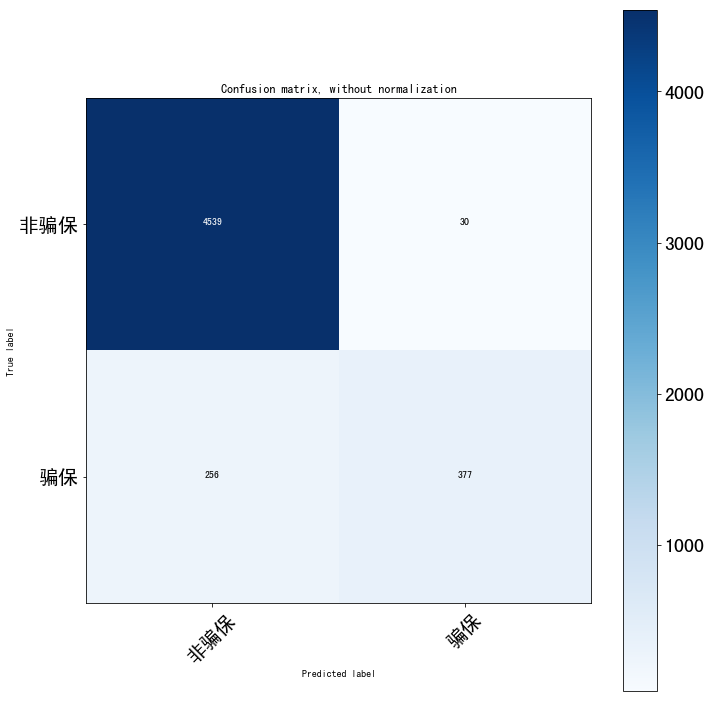

In [456]:
cnf_matrix = confusion_matrix(y_test, pred)
plot_confusion_matrix(cnf_matrix,classes=['非骗保','骗保'],title='Confusion matrix, without normalization')

             precision    recall  f1-score   support

          0       0.98      1.00      0.99      4555
          1       0.91      0.63      0.75       233

avg / total       0.98      0.98      0.98      4788



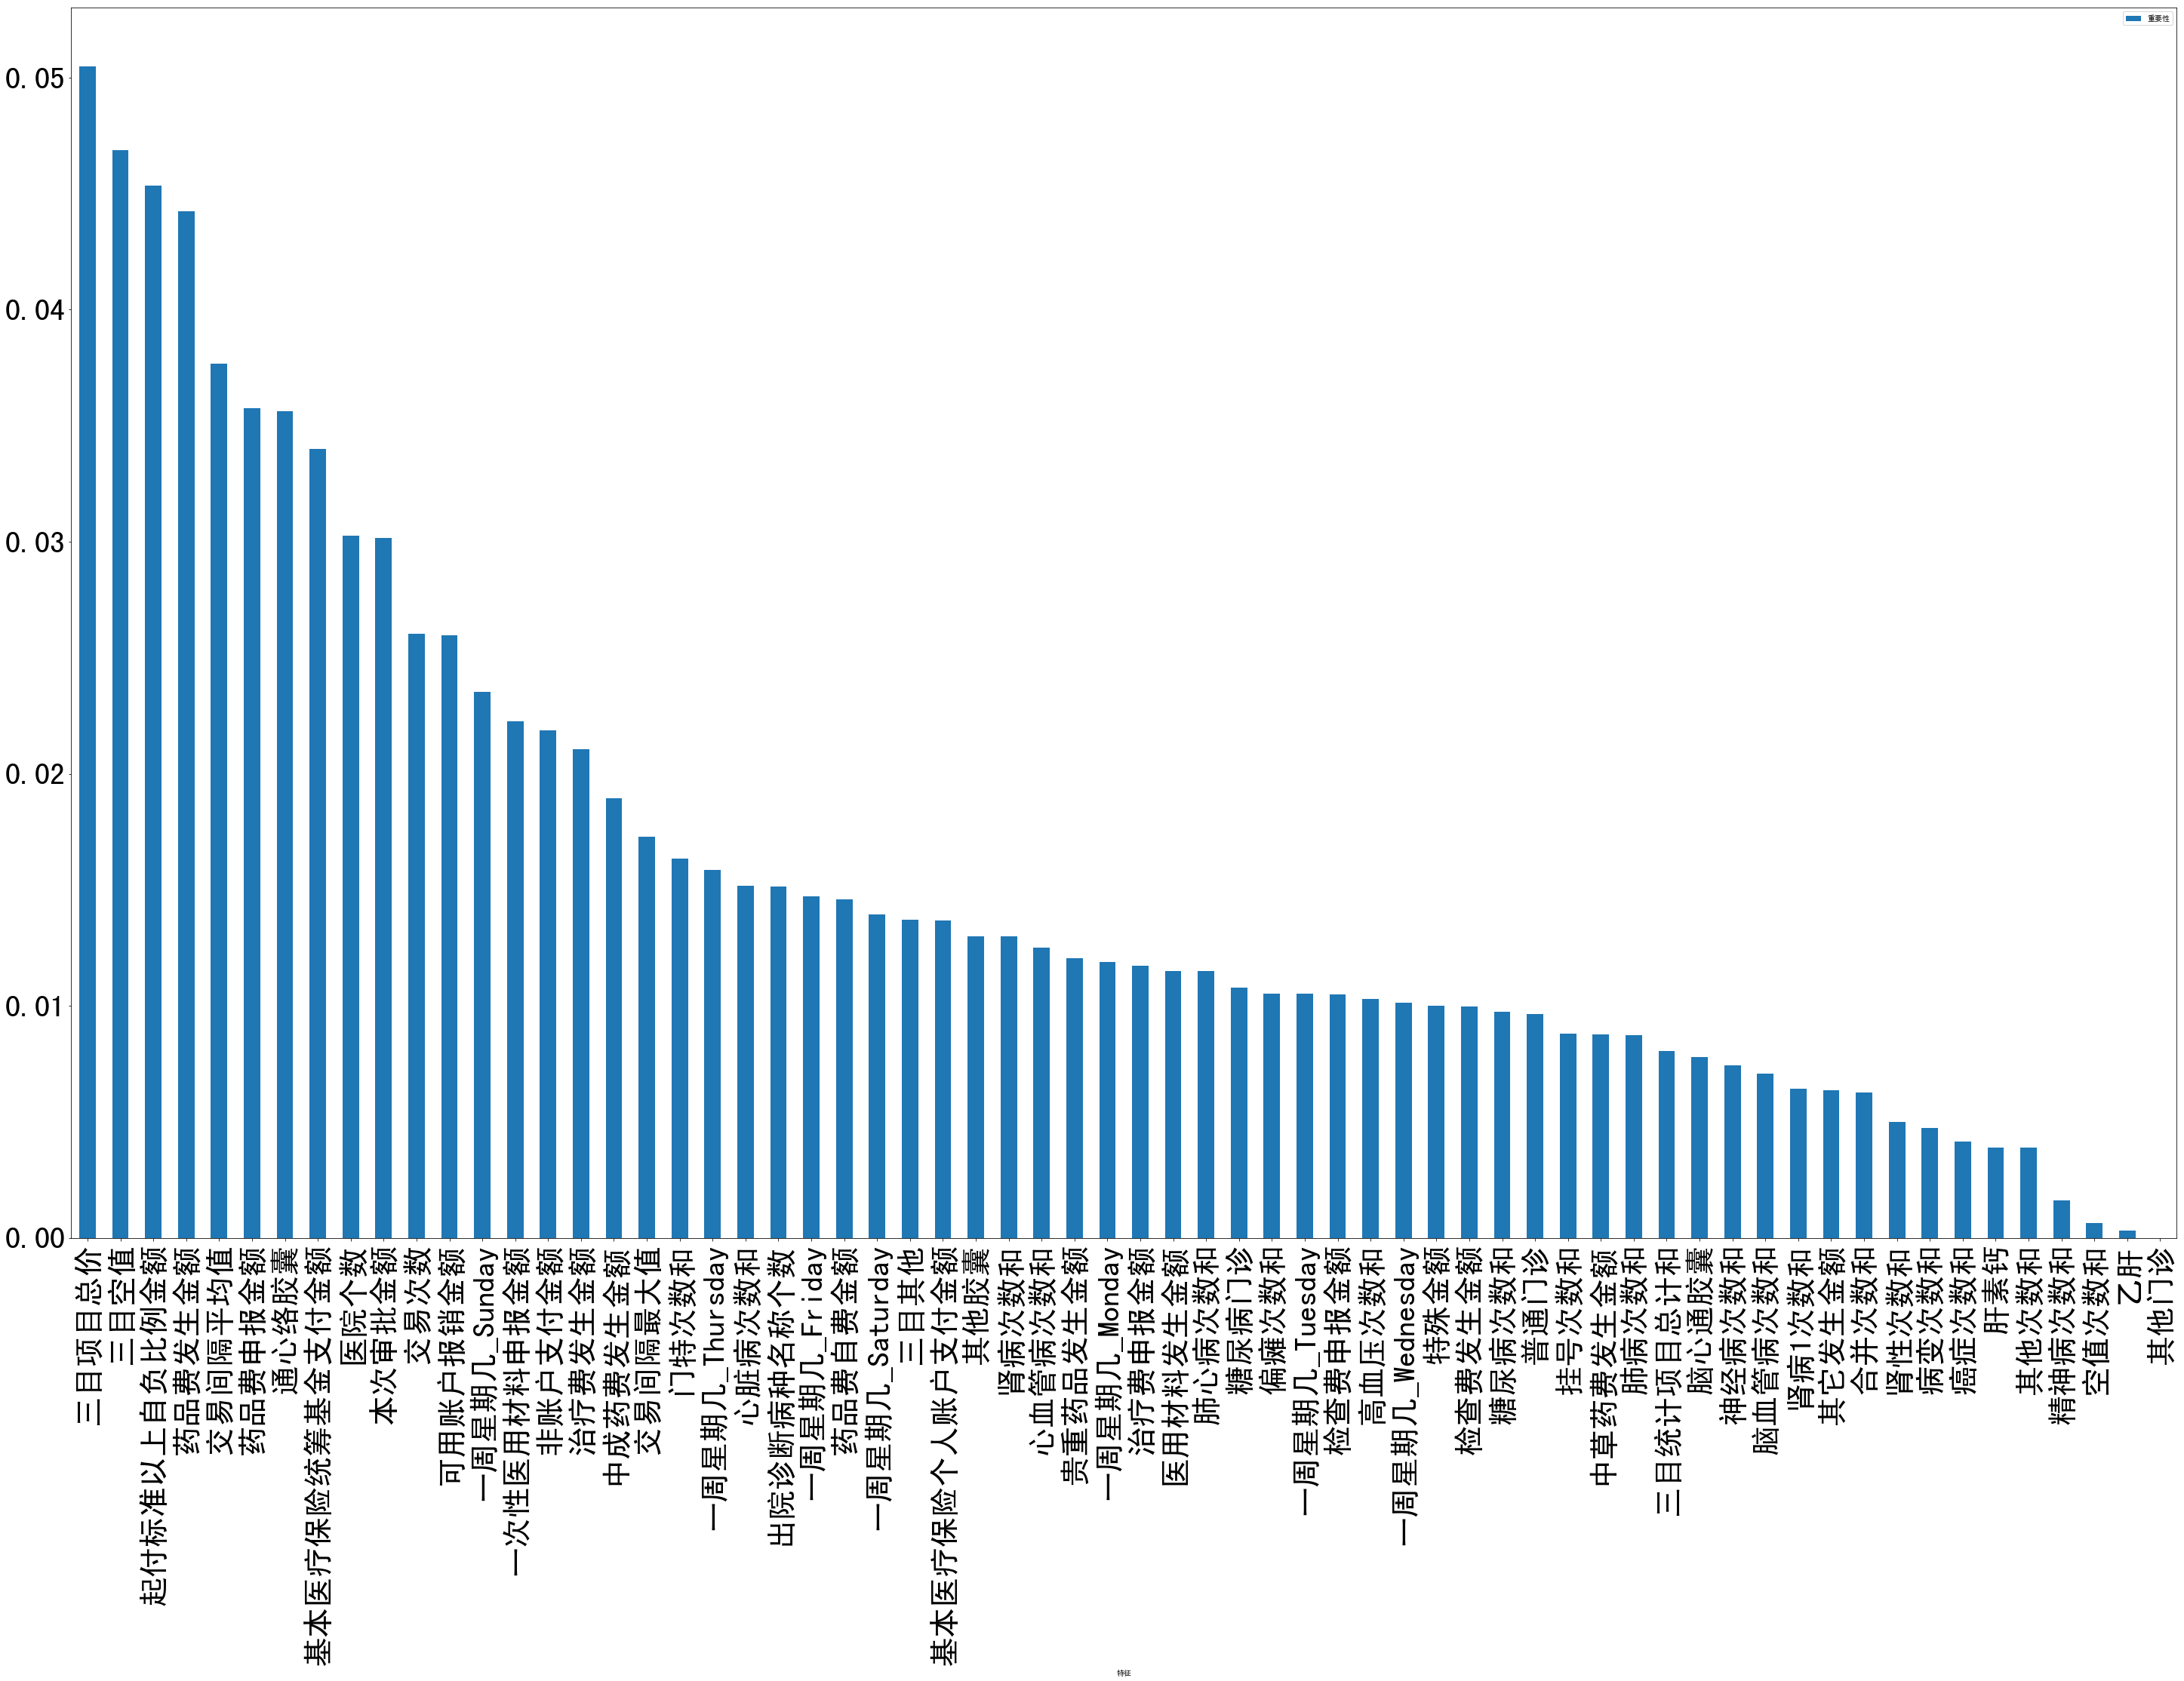

In [516]:
X_train1, X_test1, y_train1, y_test1 = train_test_split(X, y,test_size = 0.3,random_state=42)
pred1 = clf.predict(X_test1)
print(classification_report(y_test1,pred1))
fet_ipt = plot_feature_import(clf)

# 画学习曲线图

In [458]:

def plot_learning_curve(estimator, title, X, y, ylim=None, cv=None,
                        n_jobs=1, train_sizes=np.linspace(.1, 1.0, 10)):
    """
    Generate a simple plot of the test and training learning curve.

    Parameters
    ----------
    estimator : object type that implements the "fit" and "predict" methods
        An object of that type which is cloned for each validation.

    title : string
        Title for the chart.

    X : array-like, shape (n_samples, n_features)
        Training vector, where n_samples is the number of samples and
        n_features is the number of features.

    y : array-like, shape (n_samples) or (n_samples, n_features), optional
        Target relative to X for classification or regression;
        None for unsupervised learning.

    ylim : tuple, shape (ymin, ymax), optional
        Defines minimum and maximum yvalues plotted.

    cv : int, cross-validation generator or an iterable, optional
        Determines the cross-validation splitting strategy.
        Possible inputs for cv are:
          - None, to use the default 3-fold cross-validation,
          - integer, to specify the number of folds.
          - An object to be used as a cross-validation generator.
          - An iterable yielding train/test splits.

        For integer/None inputs, if ``y`` is binary or multiclass,
        :class:`StratifiedKFold` used. If the estimator is not a classifier
        or if ``y`` is neither binary nor multiclass, :class:`KFold` is used.

        Refer :ref:`User Guide <cross_validation>` for the various
        cross-validators that can be used here.

    n_jobs : integer, optional
        Number of jobs to run in parallel (default 1).
    """
    plt.figure(figsize =(20,10) )
    plt.title(title)
    if ylim is not None:
        plt.ylim(*ylim)
    plt.xlabel("Training examples")
    plt.ylabel("Score")
    train_sizes, train_scores, test_scores = learning_curve(
        estimator, X, y, cv=cv, n_jobs=n_jobs, train_sizes=train_sizes,scoring='f1')
    print(train_scores,test_scores)
    train_scores_mean = np.mean(train_scores, axis=1)
    train_scores_std = np.std(train_scores, axis=1)
    test_scores_mean = np.mean(test_scores, axis=1)
    test_scores_std = np.std(test_scores, axis=1)
    plt.grid()

    plt.fill_between(train_sizes, train_scores_mean - train_scores_std,
                     train_scores_mean + train_scores_std, alpha=0.1,
                     color="r")
    plt.fill_between(train_sizes, test_scores_mean - test_scores_std,
                     test_scores_mean + test_scores_std, alpha=0.1, color="g")
    plt.plot(train_sizes, train_scores_mean, 'o-', color="r",
             label="Training score")
    plt.plot(train_sizes, test_scores_mean, 'o-', color="g",
             label="Cross-validation score")

    plt.legend(loc="best")

    return estimator


[[ 0.87878788  0.89552239  0.92753623  0.87022901  0.91851852  0.92753623
   0.87692308  0.89855072  0.816       0.88188976  0.91851852  0.92537313
   0.94285714  0.95714286  0.92753623  0.92753623  0.91970803  0.92647059
   0.89705882  0.91176471  0.92753623  0.91044776  0.90510949  0.88888889
   0.93430657  0.84615385  0.86821705  0.94202899  0.90769231  0.90076336
   0.97183099  0.93430657  0.88549618  0.86363636  0.95035461  0.89552239
   0.94202899  0.90225564  0.87218045  0.8503937   0.83870968  0.9352518
   0.91851852  0.95774648  0.9037037   0.94366197  0.89552239  0.92857143
   0.96503497  0.91851852]
 [ 0.92250923  0.92592593  0.92418773  0.86692015  0.90298507  0.91111111
   0.9270073   0.92193309  0.88721805  0.87258687  0.86923077  0.88636364
   0.91911765  0.91176471  0.92363636  0.9270073   0.93862816  0.86923077
   0.88721805  0.90298507  0.91111111  0.87692308  0.90225564  0.91575092
   0.92193309  0.92250923  0.90636704  0.94202899  0.92134831  0.8976378
   0.90909091

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=10, n_jobs=1,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False)

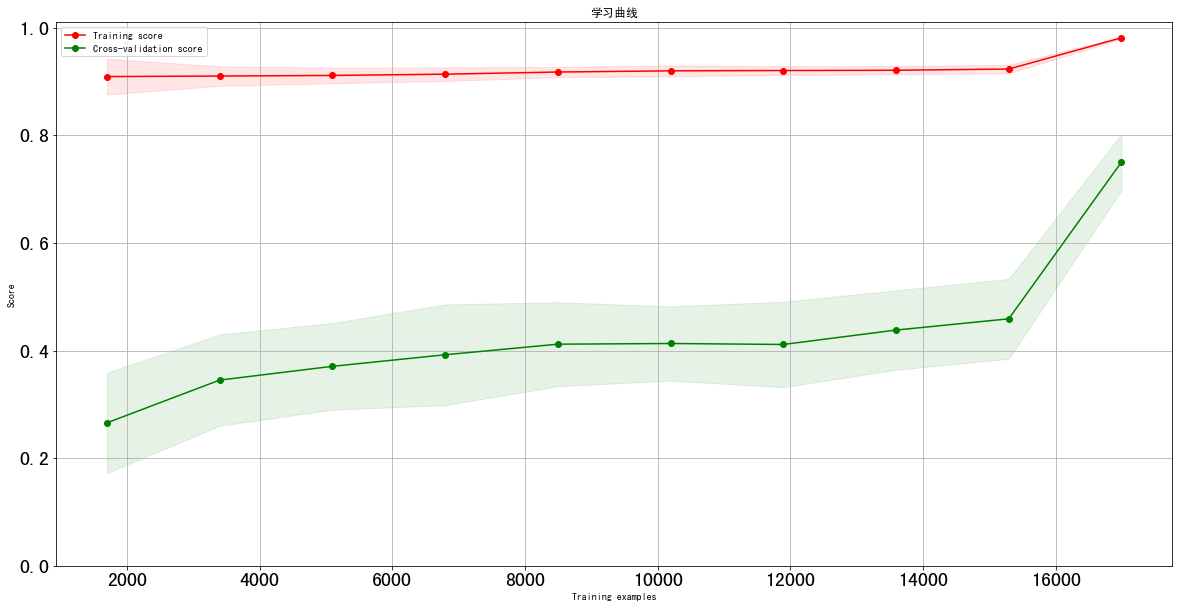

In [459]:
cv =  StratifiedKFold(n_splits=50, shuffle=True,random_state=42)
title = '学习曲线'
plot_learning_curve(clf, title, X_res,y_res,ylim=(0.0, 1.01), cv=cv, n_jobs=4)

# 特征筛选，减小过拟合

In [460]:
#利用默认参数去训练数据
new_clf = RandomForestClassifier()  # 随机森林算法
new_clf.fit(X_train[fet_ipt["特征"][:40]],y_train)        #训练模型
pred = new_clf.predict(X_test[fet_ipt["特征"][:40]])      #预测测试集  
print(classification_report(y_test,pred)) #分来器报告

print('************************************************')

             precision    recall  f1-score   support

          0       0.94      0.99      0.97      4569
          1       0.91      0.55      0.69       633

avg / total       0.94      0.94      0.93      5202

************************************************


             precision    recall  f1-score   support

          0       0.98      1.00      0.99      4555
          1       0.89      0.64      0.74       233

avg / total       0.98      0.98      0.98      4788



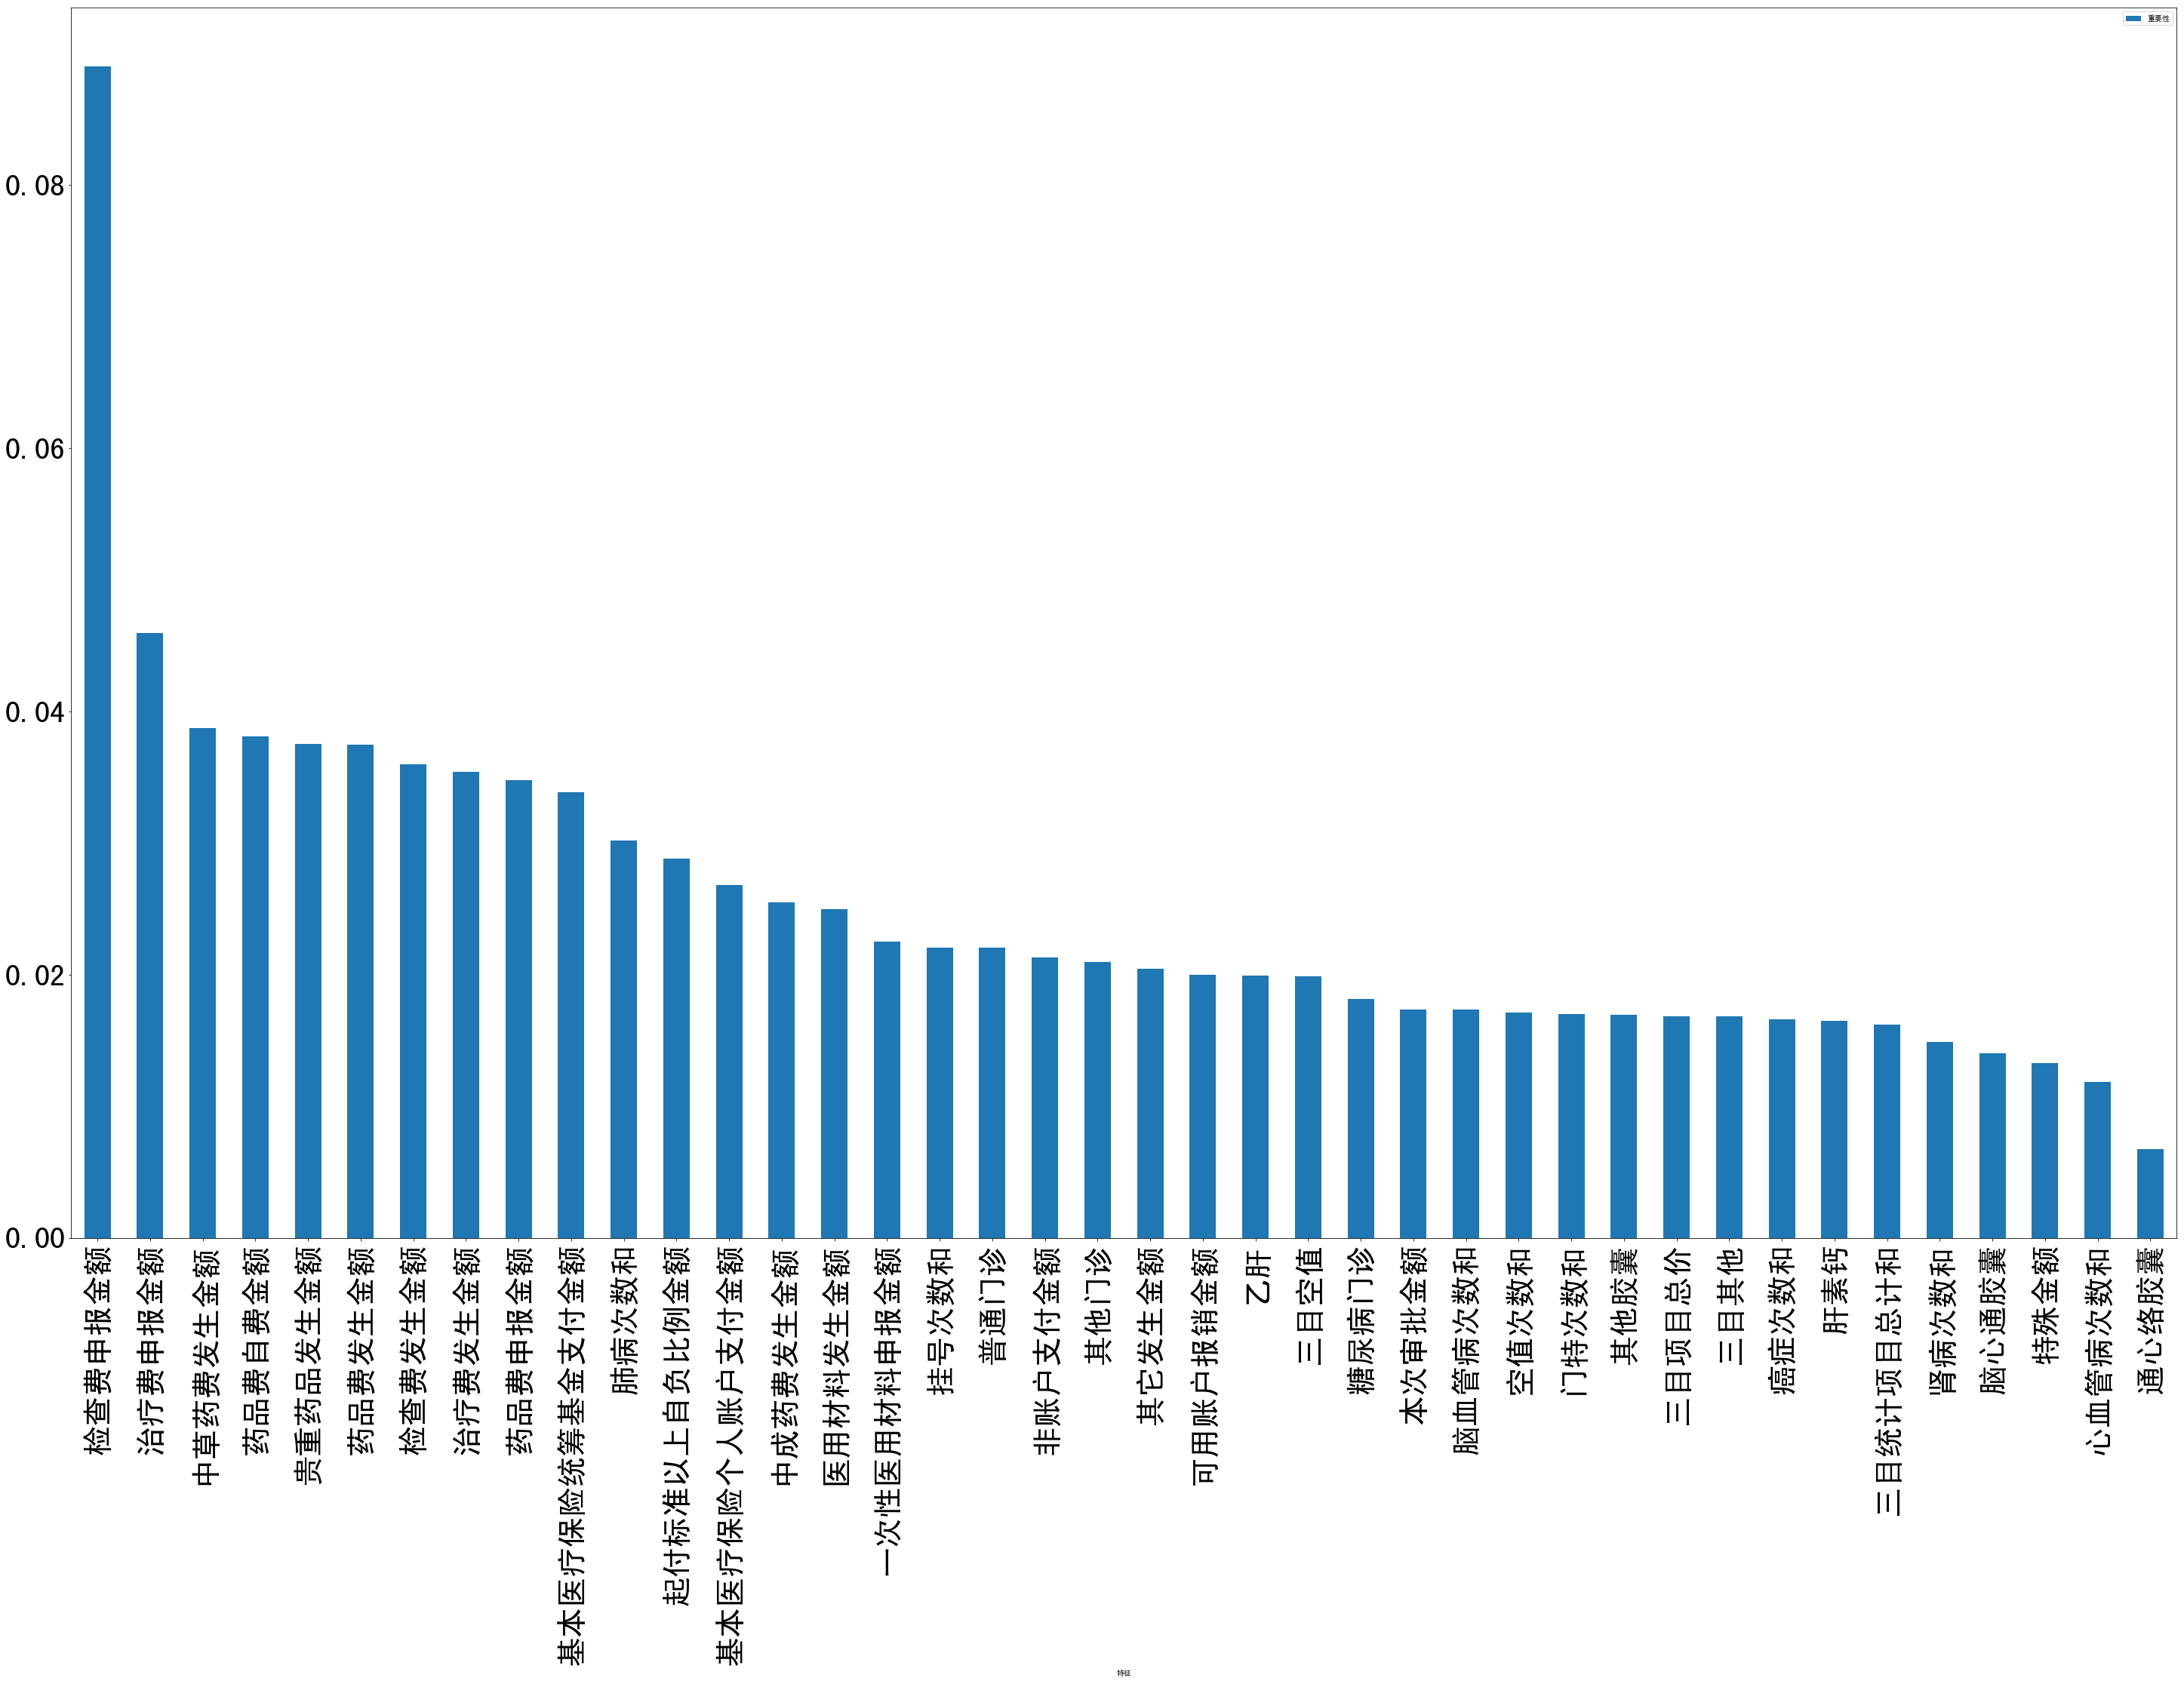

In [461]:
#****************原始数据上测试******************************88
pred1 = new_clf.predict(X_test1[fet_ipt["特征"][:40]])
print(classification_report(y_test1,pred1))
fet_ipt = plot_feature_import(new_clf)

/home/zhh/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[[ 0.92857143  0.87218045  0.89051095  0.91176471  0.90647482  0.91176471
   0.89705882  0.94366197  0.8372093   0.91176471  0.91970803  0.94366197
   0.84848485  0.89705882  0.93617021  0.91304348  0.92198582  0.92753623
   0.92537313  0.9352518   0.9352518   0.92753623  0.91176471  0.91044776
   0.92753623  0.92086331  0.86363636  0.92198582  0.86363636  0.91970803
   0.91304348  0.9352518   0.92086331  0.9037037   0.87878788  0.89705882
   0.92857143  0.94285714  0.88721805  0.91304348  0.88721805  0.88059701
   0.89552239  0.88549618  0.94285714  0.92857143  0.93617021  0.88888889
   0.87692308  0.91304348  0.84615385  0.91304348  0.91304348  0.91044776
   0.95035461  0.92753623  0.890625    0.9352518   0.90909091  0.84848485
   0.88721805  0.88721805  0.87878788  0.89552239  0.88721805  0.92957746
   0.91176471  0.92086331  0.89552239  0.92857143  0.9037037   0.87878788
   0.88059701  0.87878788  0.92086331  0.89552239  0.87218045  0.92086331
   0.91176471  0.87878788  0.88549618 

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=10, n_jobs=1,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False)

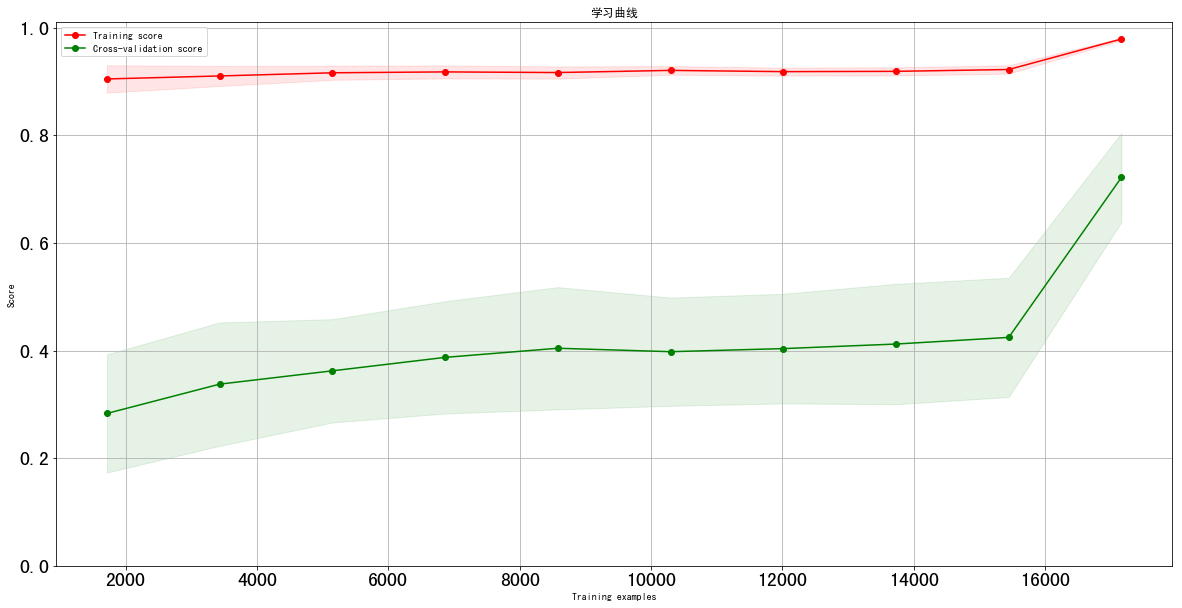

In [462]:
cv =  StratifiedKFold(n_splits=100, shuffle=True,random_state=42)
title = '学习曲线'
new_clf = RandomForestClassifier()
plot_learning_curve(new_clf, title, X_res[fet_ipt["特征"][:40]],y_res,ylim=(0.0, 1.01), cv=cv, n_jobs=4)

#  通过相关系数矩阵

In [602]:
# 计算出相关系数矩阵
corr = X_res.corr()

In [603]:
# 求出与一个特征相关性大于0.8的所有特征
def detect_corr(name,df):
    a = []
    for index,value in enumerate(df.loc[name]):
        if value >=0.8 and df.columns[index]!=name:
            a.append([df.columns[index],value])
    return a

In [604]:
def get_high_corr_columns(df):
    '''
    返回需要剔除的强相关项
    '''
    
    #求每一个特征对应的强相关特征
    high_corr_list = {}
    for i in corr.columns:
        value = detect_corr(i,corr)
        high_corr_list[i] = value
        
    a = []  # 需要保留特征项
    b =[]   #需要剔除的强相关特征
    for key,value in high_corr_list.items():  #遍历
        if value != []:    #保留低相关项
            if key not in a and key not in b:  
                a.append(key)
                for j in value:
                    b.append(j[0])
    return b   

In [605]:
delete_list = get_high_corr_columns(corr)

In [606]:
delete_list

['药品费申报金额',
 '一次性医用材料申报金额',
 '检查费申报金额',
 '治疗费申报金额',
 '基本医疗保险统筹基金支付金额',
 '三目项目总价',
 '偏瘫次数和',
 '心脏病次数和',
 '肺心病次数和',
 '交易间隔最大值',
 '医院个数']

In [607]:
# 构造新的测试集和训练集
new_X_res = X_res.drop(delete_list,axis=1)
new_X_train = X_train.drop(delete_list,axis=1)
new_X_test = X_test.drop(delete_list,axis=1)

new_X_train.shape

(12136, 53)

In [608]:
# 训练新的模型
#利用默认参数去训练数据
new_corr_rf = RandomForestClassifier()  # 随机森林算法
new_corr_rf.fit(new_X_train,y_train)        #训练模型
pred = new_corr_rf.predict(new_X_test)      #预测测试集  
print(classification_report(y_test,pred)) #分来器报告

print('************************************************')

             precision    recall  f1-score   support

          0       0.95      0.99      0.97      4569
          1       0.91      0.60      0.73       633

avg / total       0.94      0.94      0.94      5202

************************************************


             precision    recall  f1-score   support

          0       0.98      0.99      0.99      4555
          1       0.86      0.62      0.72       233

avg / total       0.97      0.98      0.97      4788



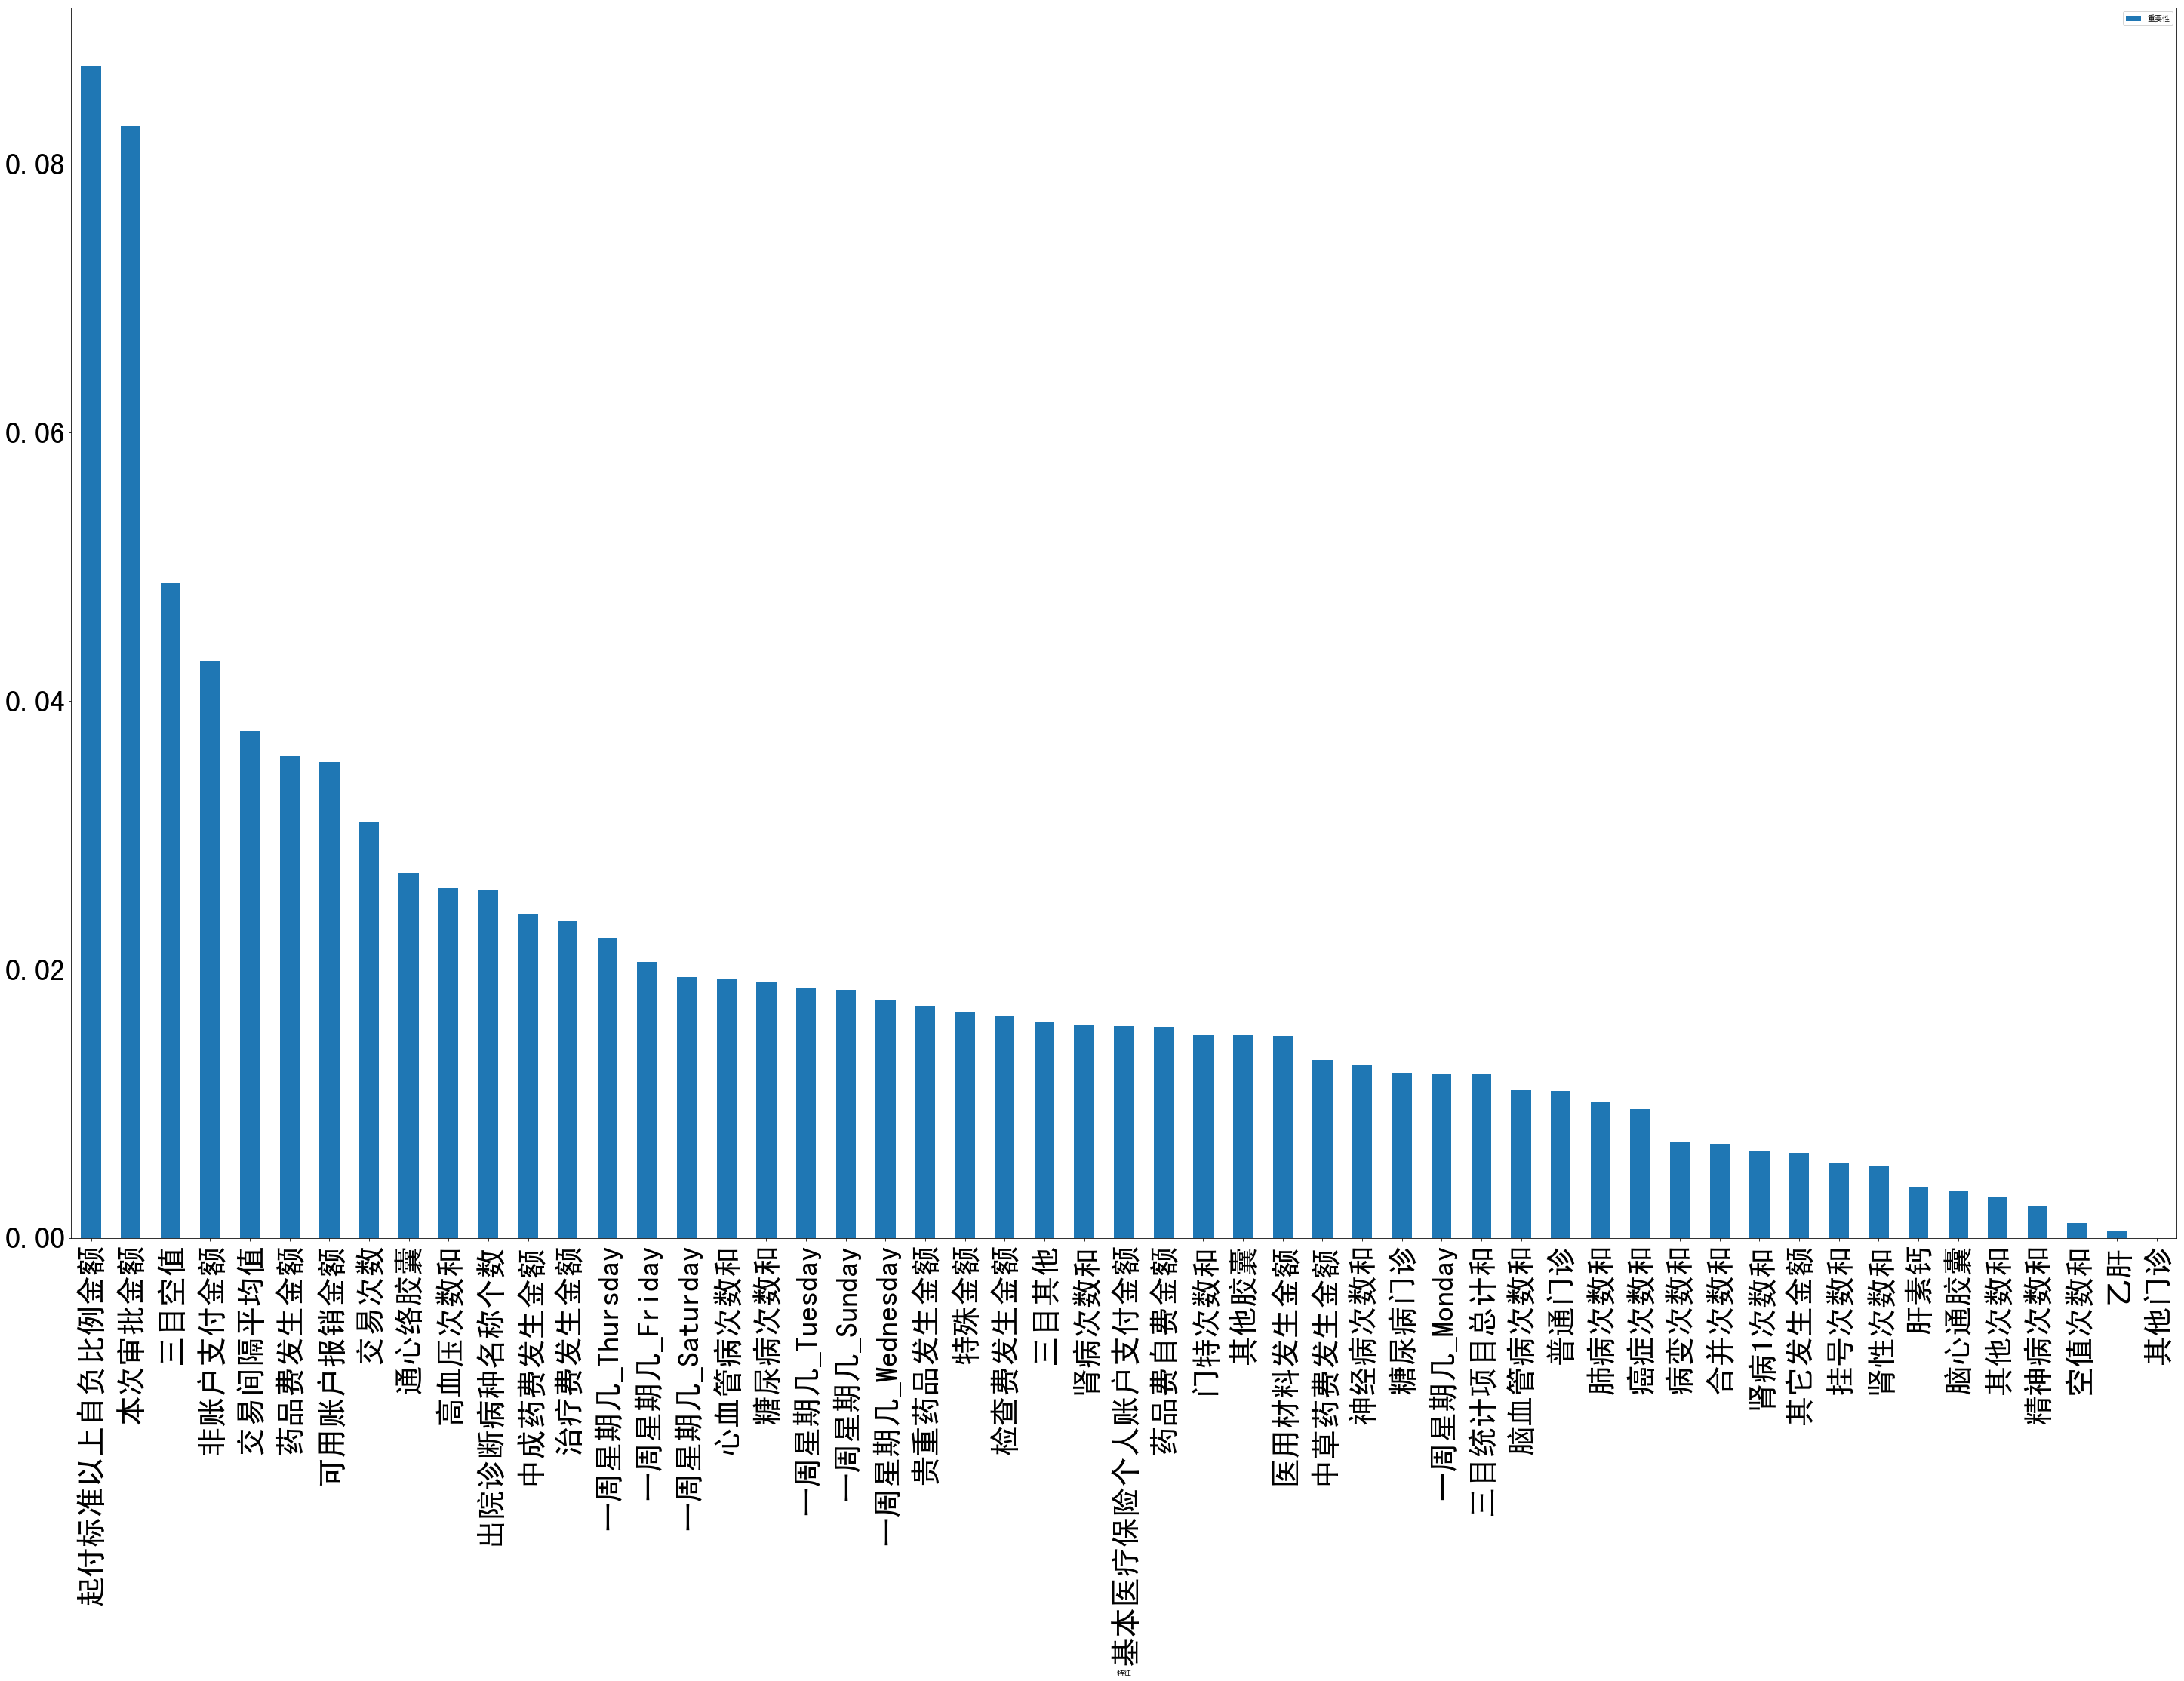

In [609]:
# 原始数据上的表现
X_train1, X_test1, y_train1, y_test1 = train_test_split(X, y,test_size = 0.3,random_state=42)
new_X_train1 = X_train1.drop(delete_list,axis=1)
new_X_test1 = X_test1.drop(delete_list,axis=1)


pred1 = new_corr_rf.predict(new_X_test1)
print(classification_report(y_test1,pred1))
fet_ipt = plot_feature_import(new_corr_rf,new_X_train)

/home/zhh/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/home/zhh/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/home/zhh/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/home/zhh/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/home/zhh/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classifi

[[ 0.9516129   0.94915254  0.96721311  0.96721311  0.91525424  0.92436975
   0.9516129   0.89655172  0.93333333  0.94214876  0.98387097  0.95081967
   0.96        0.94308943  0.94214876  0.93220339  0.95081967  0.93333333
   0.94117647  0.94214876  0.95        0.92307692  0.87719298  0.93650794
   0.93220339  0.94214876  0.94214876  0.92436975  0.90434783  0.95
   0.95867769  0.92561983  0.94214876  0.89655172  0.94117647  0.93333333
   0.91525424  0.96        0.976       0.93220339  0.95081967  0.96774194
   0.93103448  0.93333333  0.95081967  0.95798319  0.95798319  0.95081967
   0.94915254  0.89473684  0.95934959  0.90598291  0.95081967  0.96774194
   0.95934959  0.96721311  0.95        0.94214876  0.96774194  0.95081967
   0.96774194  0.94214876  0.94214876  0.92561983  0.96        0.92436975
   0.93333333  0.90909091  0.93442623  0.92561983  0.92436975  0.94214876
   0.93333333  0.95081967  0.95081967  0.976       0.97560976  0.98360656
   0.97560976  0.95867769  0.95081967  0.967

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=10, n_jobs=1,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False)

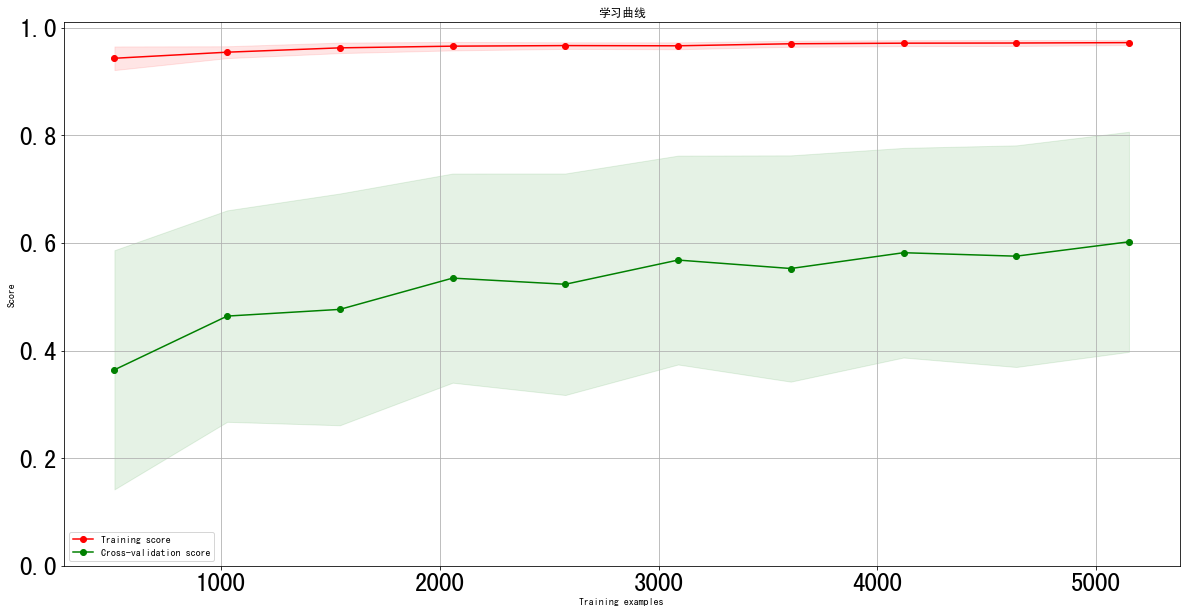

In [600]:
# ********************画学习曲线图************************************
cv =  StratifiedKFold(n_splits=100, shuffle=True,random_state=42)
title = '学习曲线'
lf_corr = RandomForestClassifier()
plot_learning_curve(lf_corr, title,new_X_test,y_test,ylim=(0.0, 1.01), cv=cv, n_jobs=4)

In [610]:
# 固化模型
joblib.dump(new_corr_rf,"/home/zhh/文档/阿里巴巴/data/8.模型训练/0812smote最新.m")

['/home/zhh/文档/阿里巴巴/data/8.模型训练/0812smote最新.m']

In [612]:
#导入
new_corr_rf = joblib.load("/home/zhh/文档/阿里巴巴/data/8.模型训练/0812smote最新.m")

# 生成提交结果

In [632]:
# 生成新样本
test = pd.read_pickle("/home/zhh/文档/阿里巴巴/data/7测试表合表/测试集总表v3.pickle")
test= test.drop(['上中下旬'],axis=1)
test["一次性医用材料申报金额"]=test.fillna(test["一次性医用材料申报金额"].median())
test = test.drop(delete_list,axis=1)

test.to_pickle("/home/zhh/文档/阿里巴巴/data/7测试表合表/测试集总表v4.pickle")
test = pd.read_pickle("/home/zhh/文档/阿里巴巴/data/7测试表合表/测试集总表v4.pickle")
test_columns = test["个人编码"]
test = test.drop(["个人编码"],axis=1)

In [633]:
test_predict = new_corr_rf.predict(test)

In [634]:
result = pd.concat([test_columns,pd.Series(test_predict)],axis=1)
result.columns =['个人编码','标签']

In [636]:
test_id = pd.read_csv("/home/zhh/文档/阿里巴巴/data/df_id_test.csv",header=None)
test_id.columns = ['个人编码']

In [638]:
result_label =pd.merge(test_id,result,how='left')

In [643]:
result_label.to_csv('/home/zhh/文档/阿里巴巴/data/提交结果201708130118.csv',sep=','
                    ,header=None,index=None)